# EyeFeatures: From Gazes to Fixations

Process of extracting fixations from raw gazes determines all future characteristics of fixations and saccades, thus being quite important. This tutorial covers `eyefeatures.preprocessing` module which offers algorithms to control this extraction and to make it as smooth as possible.

Let's load simple dataset with raw gazes.

In [1]:
import os
from os.path import join

import pandas as pd

import warnings
warnings.simplefilter("ignore")

In [2]:
participant = 'Participant'
text = 'tekst'
x = 'norm_pos_x'
y = 'norm_pos_y'
t = 'gaze_timestamp'
pk = [participant, text]

In [3]:
data = pd.read_csv("../data/gazes/gazes_subset.csv")
data.head()

,Participant,gaze_timestamp,norm_pos_x,norm_pos_y,tekst
0,1,317242.694809,0.241581,0.503806,1
1,1,317242.701080,0.246285,0.506364,1
2,1,317242.708403,0.241066,0.517243,1
3,1,317242.715197,0.239291,0.515405,1
4,1,317242.721633,0.239144,0.516382,1


Let's pick some object and keep track of it. In case of this dataset, single object is triple (subject, film, frame). Since each object contains small amount of data, we can analyze scanpath of particular person watching a particular movie, i.e. ignoring frame and defining object as (subject, film).

In [4]:
participant_id = 1
text_id = 1

def get_object(df: pd.DataFrame):
    filter_object = (df[participant] == participant_id) & (df[text] == text_id)
    return df[filter_object]

Let's use EyeFeatures toolkit to get a grasp of how our object's scanpath looks like.

In [5]:
from eyefeatures.visualization.static_visualization import scanpath_visualization

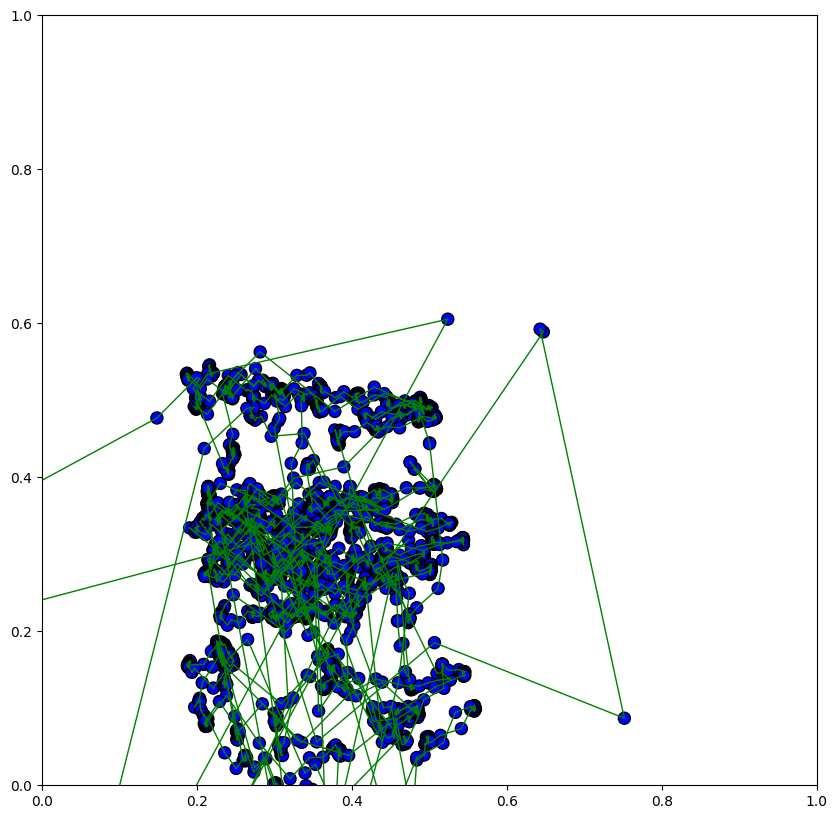

In [6]:
scanpath_visualization(get_object(data), x, y, with_axes=True, path_width=1, axes_limits=(0, 1, 0, 1))

### 1. Fixation Extraction

While squashing gazes, we would like to extract fixations and keep the path trajectory. Thus, the general approach is as follows: mark each gaze with $0$ (not a part of fixation) or $1$ (a part of fixation), then squash consecutive ones into single fixation.  Here we denote $n$ fixations as triplets $\{(x_i, y_i, t_i)\}_{i=1}^{n}$ - x coordinate, y coordinate, timestamp. `eyefeatures.preprocessing.fixation_extraction` has three algorithms for fixations extraction:

1. IVT  - velocity threshold identification algorithm. Gazes that have velocity below threshold are considered to be fixations, since high velocities are attributes of saccades. If $a$ is an algorithm and $d$ some metric in $\mathbb{R}^2$, then for single fixation:

$$a(i) = \left[\frac{d((x_i, y_i), (x_{i + 1}, y_{i + 1}))}{t_{i + 1} - t_i} \leq T\right]$$

2. IDT finds sequences of gazes that are not
too short, not too long, and are placed close enough to each other. For example,
user may define these restrictions to have fixations at
least $200$ ms, at most $600$ ms, and
with dispersion less than $0.5$ units. Algorithm uses sliding window to
first select gazes satisfying maximum duration constraint. Then,
it uses binary search to find the widest window
that satisfies the dispersion constraints inside the sliding window.
Finally, minimum dispersion requirement is checked, and if fulfilled,
the sequence is marked as a single fixation.


3. IHMM - hidden Markov model identification algorithm. Algorithm finds a sequence of fixations that maximizes the log probability of observing given velocities of gazes under conditions of Hidden Markov Model. More formally, denote velocity of $i$-th gaze as $\displaystyle v_i = \frac{d((x_i, y_i), (x_{i + 1}, y_{i + 1}))}{t_{i + 1} - t_i}$ - this is observed process, while hidden process is sequence of zeros and ones $\{s_i\}_{i=1}^{n}$, as discussed previously, $1$ indicating fixation. We fix some prior distribution of velocities (normal is taken as empirical rule) and transition matrix, then, under assumption of Markov process, i.e. $P(s_i = b|v_{i - 1}, ..., v_1) = P(s_i = b|v_{i - 1}, ..., v_{i - k})$ for some $k \geq 1$, probability is maximized in greedy manner.

Let's use IDT since it is a common choice among eyefeatures software products.

In [7]:
from eyefeatures.preprocessing.fixation_extraction import IDT

IDT has two parameters: `min_duration` of fixation and `max_dispersion` of gazes within fixation. They provide a great control over the desired results.

In [8]:
preprocessor = IDT(x=x, y=y, t=t, pk=pk, min_duration=0.5, max_dispersion=0.5, max_duration=5)

fixations = preprocessor.fit_transform(data)
fixations

,Participant,tekst,norm_pos_x,norm_pos_y,start_time,end_time,distance_min,distance_max,dispersion,diameters,centers,duration,saccade_duration,saccade_length,saccade_angle,saccade2_angle
0,1,1,0.261095,0.439568,317242.694809,317244.261180,0.000008,0.163336,0.476200,0.447168,"[0.26978281912696733, 0.2982622328901172]",1.566372,0.000000,0.000000,0.000000,0.000000
1,1,1,0.278722,0.164626,317244.273837,317246.184184,0.000020,0.214331,0.493642,0.405614,"[0.2910625032822163, 0.1982021669431278]",1.910347,0.012657,0.275507,273.668414,13.860336
2,1,1,0.340707,0.509400,317246.578172,317249.525303,0.000029,0.313150,0.396658,0.315787,"[0.3431115936291729, 0.5135625103911892]",2.947131,0.393987,0.350302,79.808078,14.391533
3,1,1,0.350160,0.380658,317249.801513,317254.793279,0.000000,0.121382,0.419438,0.340191,"[0.34663493546708635, 0.4025502251881663]",4.991766,0.276210,0.129089,274.199611,171.687878
4,1,1,0.338269,0.215270,317254.805193,317259.796214,0.000000,0.357914,0.468017,0.377124,"[0.3634474419928634, 0.16512318042269397]",4.991021,0.011914,0.165815,265.887489,142.738272
5,1,1,0.295685,0.166924,317259.808574,317261.384745,0.000022,0.196554,0.475589,0.429357,"[0.29910106021574867, 0.15546331016248877]",1.576171,0.012360,0.064425,228.625761,26.311673
6,1,1,0.346321,0.355075,317261.539669,317263.812044,0.000000,0.215157,0.462429,0.388555,"[0.39205210487319875, 0.2443357155482297]",2.272374,0.154924,0.194845,74.937434,36.981137
7,1,1,0.384764,0.259534,317263.826622,317265.236978,0.000000,0.346267,0.498731,0.448065,"[0.3797224191155708, 0.15968173057298432]",1.410356,0.014579,0.102986,291.918571,101.175097
8,1,1,0.436244,0.269301,317265.249594,317269.824622,0.000036,0.152877,0.490870,0.422792,"[0.4710875049736325, 0.27212431928317216]",4.575028,0.012616,0.052398,10.743474,7.514506
9,1,1,0.333483,0.263504,317269.837356,317270.931999,0.000075,0.418614,0.493908,0.230166,"[0.337747722909397, 0.2777624383886774]",1.094643,0.012734,0.102924,183.228968,315.363417


Preprocessing algorithms compute a variety of features alongside with fixation extraction. For example, lengths and durations of saccades between fixations, as well as angles between succeeding and preceding saccades.

Now, let's see how the path of our object has changed:

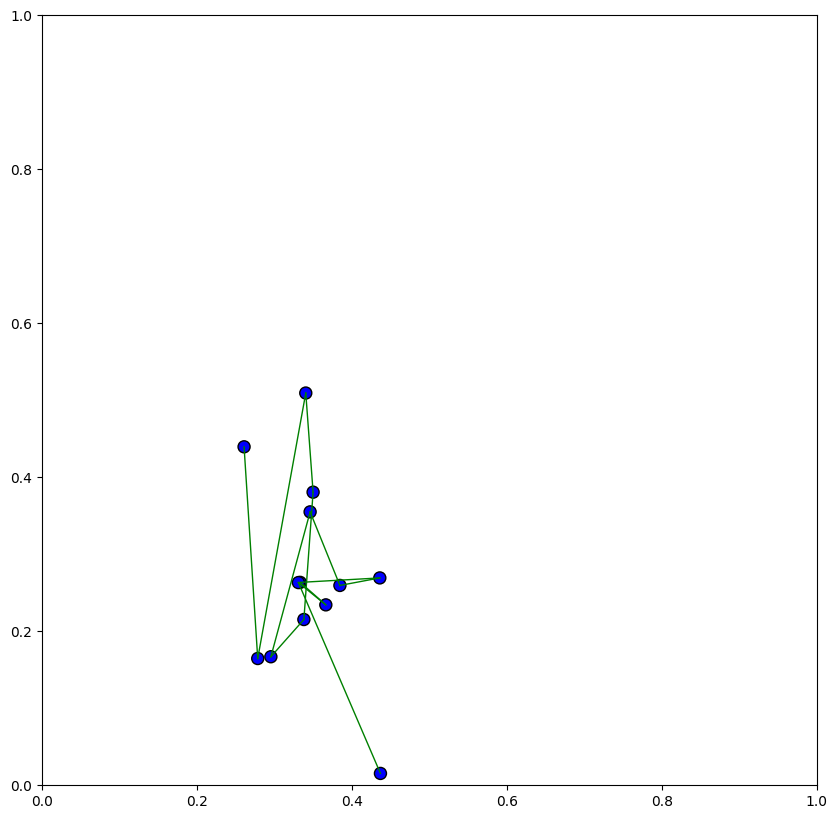

In [9]:
scanpath_visualization(get_object(fixations), x, y, with_axes=True, path_width=1, axes_limits=(0, 1, 0, 1))

### 2. Filtering gazes.

`eyefeatures.preprocessing.smoothing` provides 4 filters to smooth either gazes before the process of fixation extraction or fixations after an extraction is completed:
1. Savitzkiy-Golay filter - fits $k$-degree polynomial using $k$ last points in sequence using OLS.
2. FIR filter - weighted sum of $k$ previous values (convolution of signals).
3. IIR filter - similar to FIR filter but with two convolution signals.
4. Wiener filter. This filter assumes the following model of distortion:

$$g(x) = f(x) * h(x) + s(x)$$

where $f$ is true signal, $h$ is distortion signal, $*$ is convolution operation, $s$ is noise, and $g$ is distorted signal (observed signal). Wiener's approach considers input signal and noise as random variables and finds such estimator $\hat{f}$ which minimizes the variance of $\hat{f} - f$. It could be shown that in the underlined model the minimum is achieved (in frequency domain) at:

$$\hat{F}(x) = \frac{\overline{H(x)}}{|H(x)|^2 + K}G(x)$$

where
* $\hat{F}(x)$ - Fourier-image of $f$.
* $H(x)$ - Fourier-image of distorting function $h$.
* $\overline{\cdot}$ - complex inverse.
* $|\cdot|$ - complex modulus.
* $K$ - approximation constant.

Filters are often applied before fixation extraction. Let's do it using `sklearn`'s pipeline.

In [10]:
from eyefeatures.preprocessing.smoothing import WienerFilter, SavGolFilter
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),                                      # IDT algorithm
    ("wf_filter", WienerFilter(x=x, y=y, t=t, pk=pk, K='auto')),         # Wiener filter
    ("sg_filter", SavGolFilter(x=x, y=y, t=t, pk=pk, window_length=4)),  # Savitzkiy-Golay filter
])

fixations_smooth = pipe.fit_transform(data)

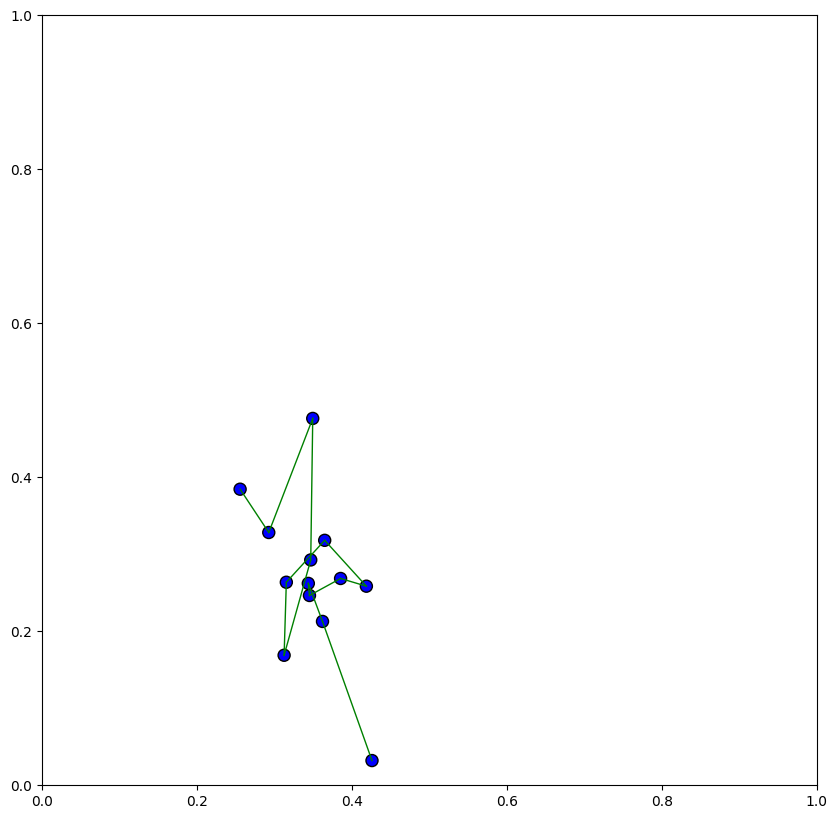

In [11]:
scanpath_visualization(get_object(fixations_smooth), x, y, with_axes=True, path_width=1, axes_limits=(0, 1, 0, 1))

Number of fixations without filtering:

In [12]:
len(get_object(fixations))

13

Number of fixations with filtering:

In [13]:
len(get_object(fixations_smooth))

13

### References

1. [Sample dataset](https://www.inb.uni-luebeck.de/index.php?id=515), static images.
2. [Salvucci & Goldberg (2000)](https://www.researchgate.net/publication/220811146_Identifying_fixations_and_saccades_in_eye-tracking_protocols). Identifying saccades and fixations in eye-tracking protocols. Served as the source of fixation extraction algorithms
3. Savitzkiy-Golay, FIR, IIR classes are wrappers of `scipy.signal` methods.
4. About [Wiener filter](https://en.wikipedia.org/wiki/Wiener_filter) on Wikipedia.